<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-Linear-Regression" data-toc-modified-id="Модель-Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель Linear Regression</a></span></li><li><span><a href="#Модель-Ridge" data-toc-modified-id="Модель-Ridge-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель Ridge</a></span></li><li><span><a href="#Модель-CatBoost-Regression" data-toc-modified-id="Модель-CatBoost-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель CatBoost Regression</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель LightGBM</a></span></li><li><span><a href="#Модель-Random-Forest" data-toc-modified-id="Модель-Random-Forest-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель Random Forest</a></span></li><li><span><a href="#Модель-Dummy-Regression" data-toc-modified-id="Модель-Dummy-Regression-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Модель Dummy Regression</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Техническое задание**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Импортируем необходимые модули
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
import itertools
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from warnings import simplefilter
from catboost import Pool, CatBoostRegressor, cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Снимем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# Снимем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# Игнорируем предупреждения
pd.set_option('chained_assignment', None)

# Игнорировать все предупреждения
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Загрузим данные
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
except:
    data = pd.read_csv('taxi.csv', parse_dates=['datetime'])

In [4]:
SEED = 12345

In [5]:
print(data.shape)

(26496, 2)


In [6]:
print(data.head(3))
print()
print('Информация датасета:')
print(data.info())
print()
print('Описание датасета:')
print(data.describe())
print()
print(f'Количествово пропусков:{data.isna().sum()}') 
print()
print(f'Количествово дубликатов:{data.duplicated().sum()}')
print()
print('Уникальные значения датасета:')
print(data.nunique())

             datetime  num_orders
0 2018-03-01 00:00:00           9
1 2018-03-01 00:10:00          14
2 2018-03-01 00:20:00          28

Информация датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None

Описание датасета:
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

Количествово пропусков:datetime      0
num_orders    0
dtype: int64

Количествово дубликатов:0

Уникальные значения датасета:
datetime      26496
num_orders       81
dtype: int64


In [7]:
# Проверим индекс на монотонность
data.index.is_monotonic

True

In [8]:
# Отсортируем индекс таблицы
data.sort_index(inplace=True)

In [9]:
data.set_index('datetime', verify_integrity=True, inplace=True)

In [10]:
# Измененим интервал со значениями ряда с 10 минут на 1 час, при этом агрегированным значением ряда выберем сумму
df = data.resample('1H').sum()

In [11]:
decomposed = seasonal_decompose(df)
decomposed_day = seasonal_decompose(df.resample('1D').sum())

In [12]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

**Промежуточный вывод:**

Были выполнены следующие задачи:

- Чтение данных и установка признака "datetime" в качестве индекса.
- Выполнено ресемплирование с интервалом в один час с агрегирующией функцией значения ряда - sum().
- Данные были отсортированы и преобразованы во временной ряд.
- Выяснено, что дубликатов и пропусков нет.
- Проведена проверка на монотонность временного ряда.
- Выяснено, что тип данных в столбце num_orders менять не надо. 

## Анализ

Построим наш временной ряд количества заказов.

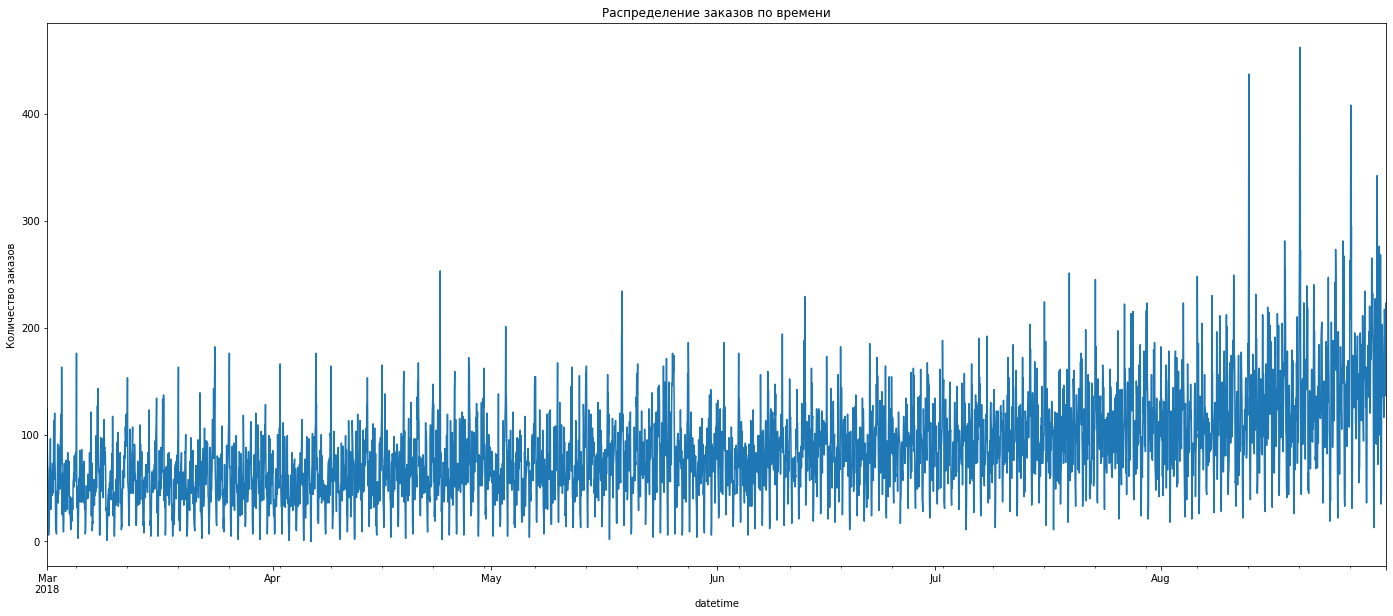

In [13]:
df['num_orders'].plot(figsize=(168,10))
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по времени');

Временной ряд на графике имеет множественные колебания, потому что у него меняется среднее значение. Применим скользящее среднее.

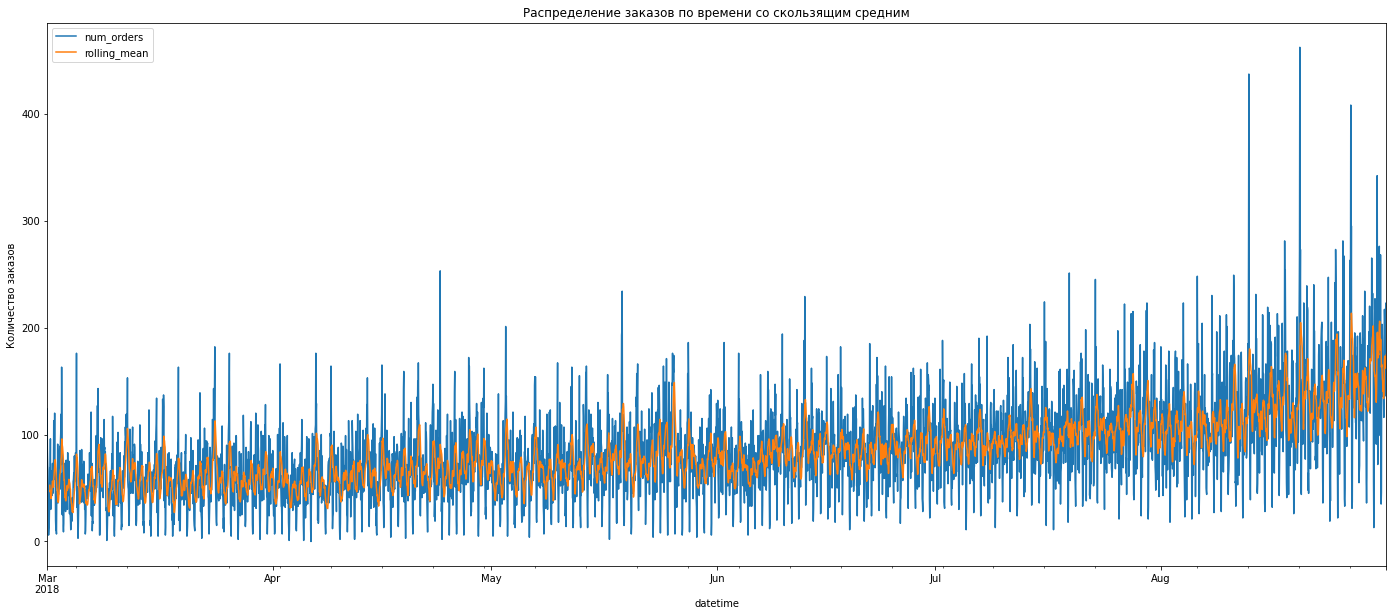

In [14]:
df['rolling_mean'] = df['num_orders'].rolling(10).mean()
df['num_orders'].plot(figsize=(168,10))
df['rolling_mean'].plot(ax=plt.gca())
plt.legend()
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по времени со скользящим средним');

У скользящего среднего временного ряда по-прежнему наблюдается тренд. Ряд не стационарен, посмотрим стационарны ли разности временного ряда.

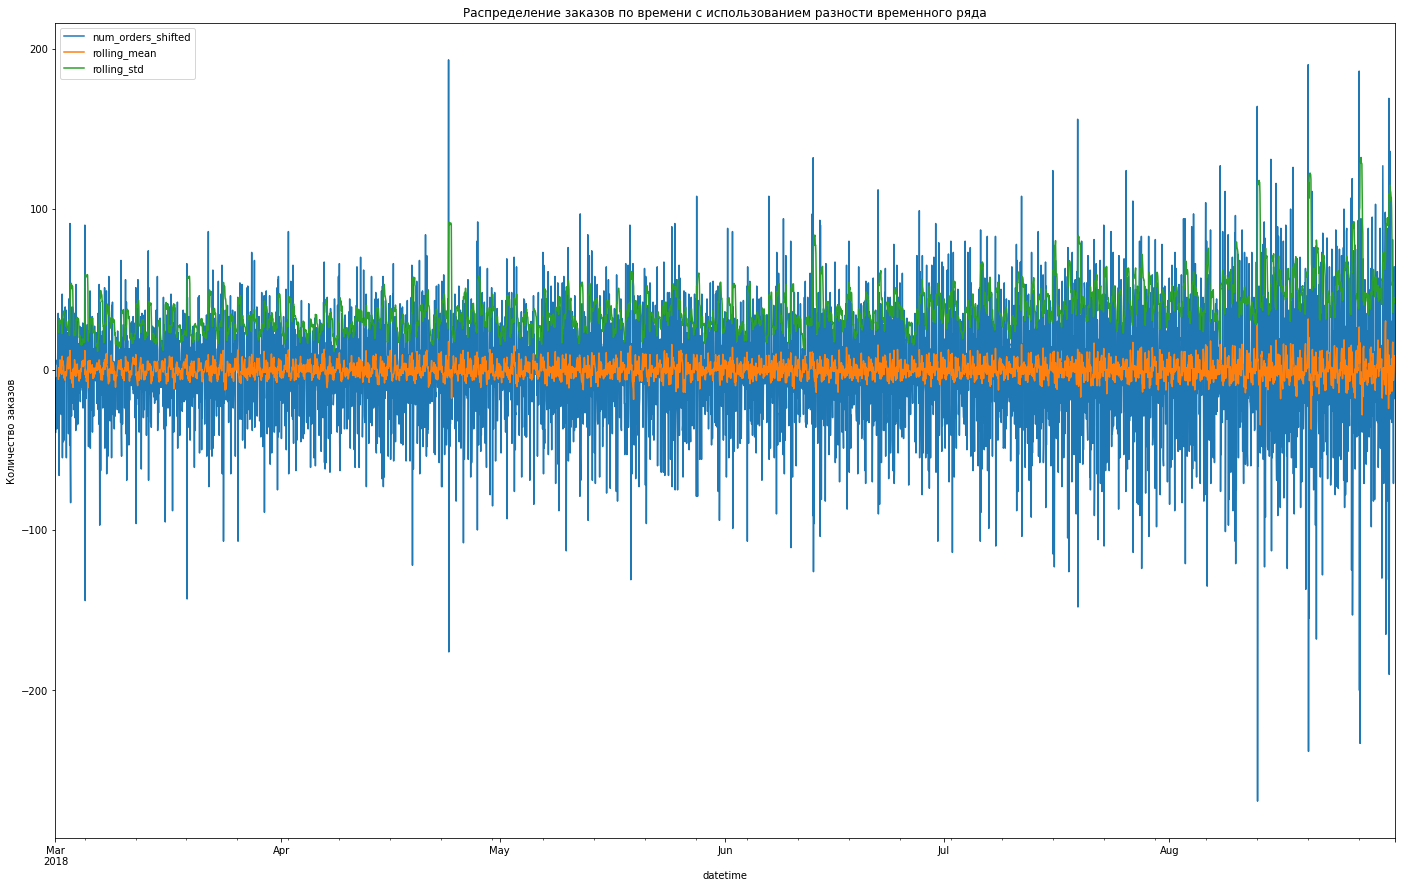

In [15]:
df['num_orders_shifted'] = df['num_orders'] - df['num_orders'].shift()
df['rolling_mean'] = df['num_orders_shifted'].rolling(10).mean()
df['rolling_std'] = df['num_orders_shifted'].rolling(10).std()
df['num_orders_shifted'].plot(figsize=(24,15))
df['rolling_mean'].plot(ax=plt.gca())
df['rolling_std'].plot(ax=plt.gca())
plt.legend()
plt.ylabel('Количество заказов')
plt.title('Распределение заказов по времени с использованием разности временного ряда');

Ряд стал более стационарным, скользящее стандартное отклонение также не имеет аномалий.

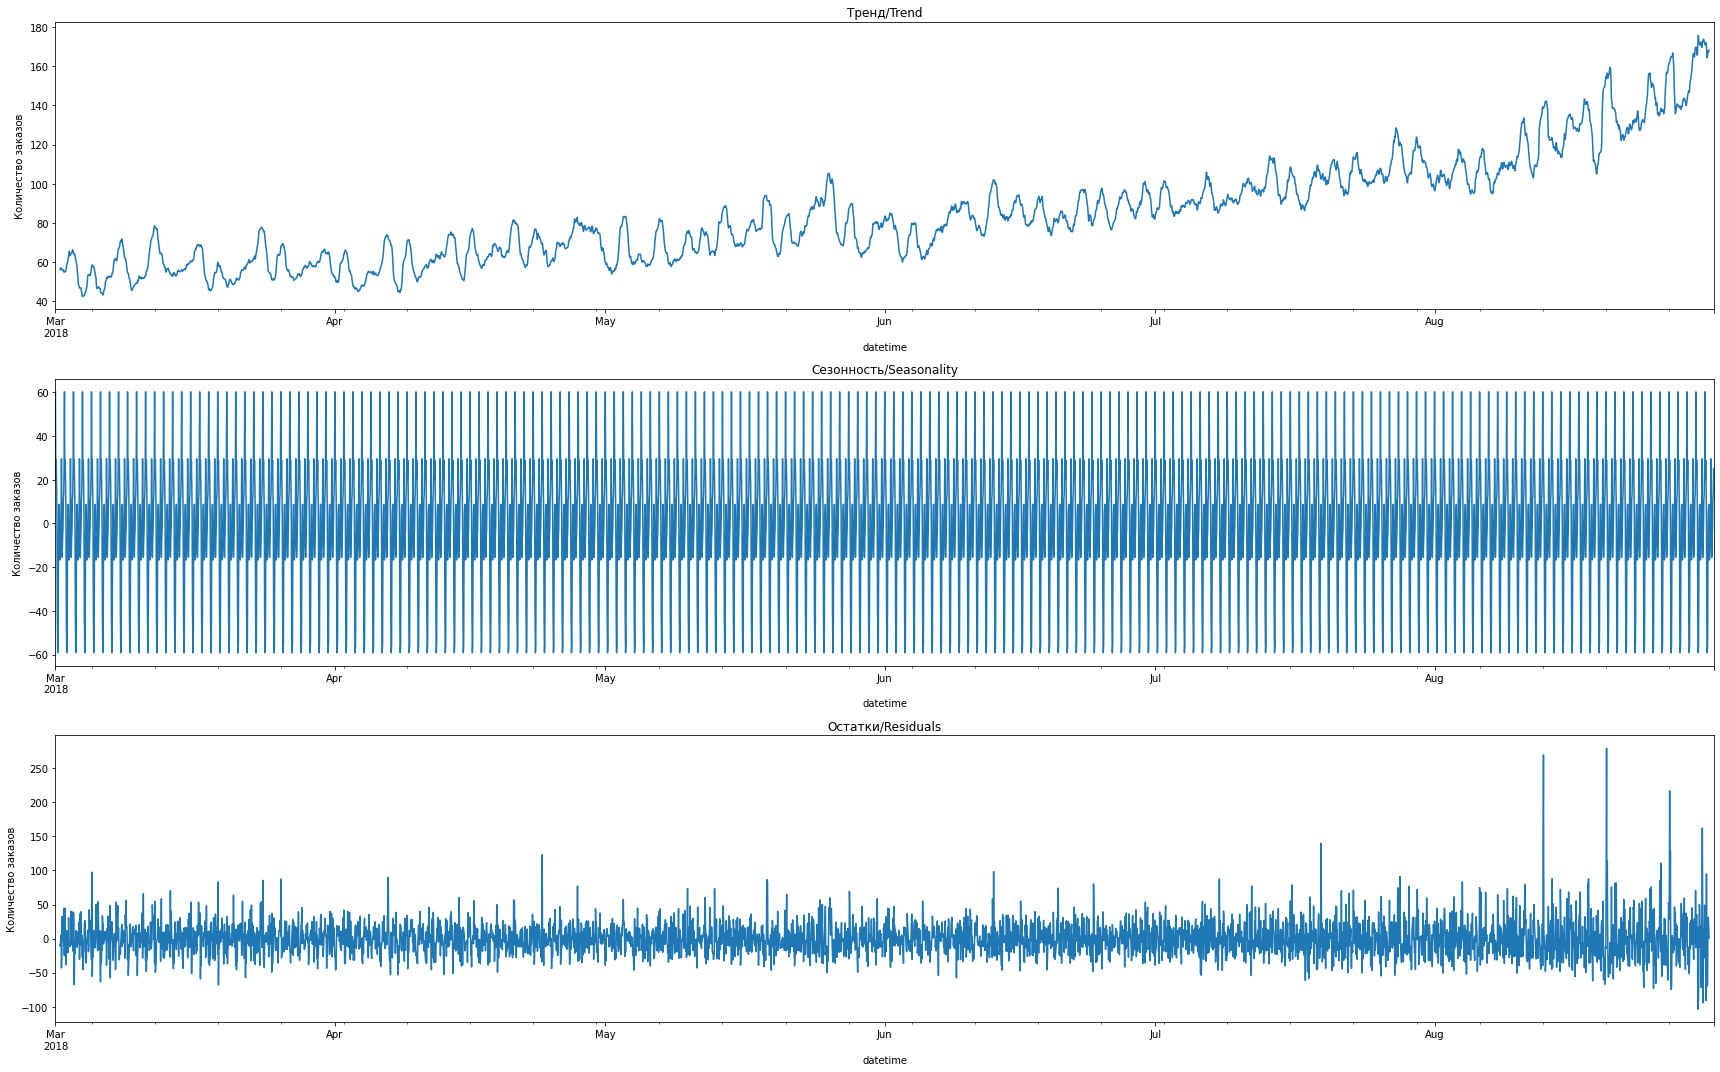

In [16]:
decomposed = seasonal_decompose(df['num_orders']) 

plt.figure(figsize=(168,15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд/Trend')
plt.ylabel('Количество заказов')
plt.subplot(312)
#decomposed.seasonal.plot(ax=plt.gca())
decomposed.seasonal['2018-03-01': '2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность/Seasonality')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки/Residuals')
plt.ylabel('Количество заказов')
plt.tight_layout()

Разложение временного ряда на составляющие, показало что в данных присутствует тренд - линейное увеличение заказов на протяжении года, также в данных присутствует шум. Для сезонности выбран неверный машстаб, ничего не видно, поэтому в качестве сезонности рассмотрим первую неделю:

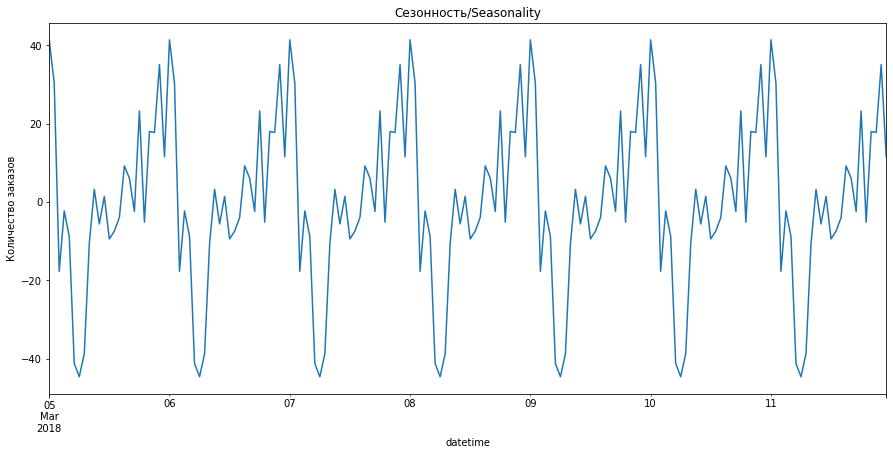

In [17]:
decomposed = seasonal_decompose(df['num_orders']['2018-03-05':'2018-03-11']) 

plt.figure(figsize=(15, 15))
plt.subplot(211)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность/Seasonality')
plt.ylabel('Количество заказов');

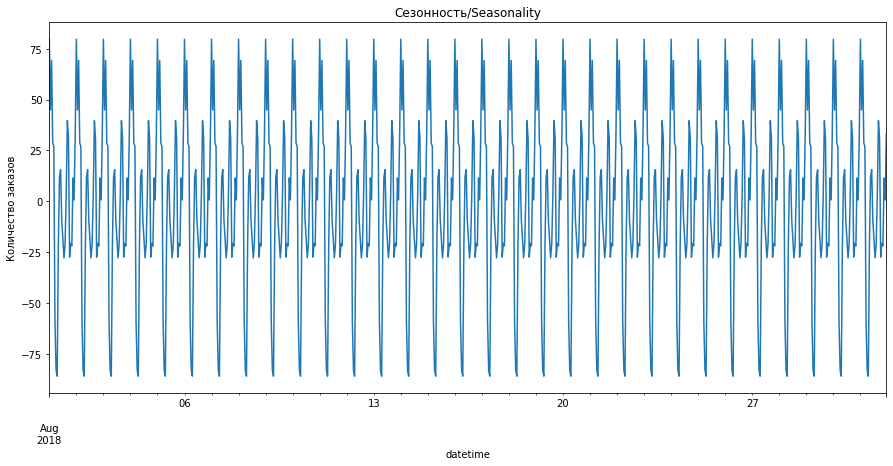

In [18]:
# Также рассмотрим сезонность за последний месяц
decomposed = seasonal_decompose(df['num_orders']['2018-08-01':'2018-08-31']) 

plt.figure(figsize=(15, 15))
plt.subplot(211)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность/Seasonality')
plt.ylabel('Количество заказов');

Здесь присутствуют циклично повторяющиеся закономерности, в данном случае мы видим, что рост количества заказов каждый день происходит в одинаковые часы (пик вечером), в воскресенье чуть меньше.

**Промежуточный вывод:**

- Временной ряд имеет множественные колебания, в данных наблюдается плавное измение тренда за рассматриваемый период, ряд не стационарен. Однако, разности временного ряда являются стационарными. 
- Разложение временного ряда на тренд, сезонность и остаток показало линейное увеличение заказов на протяжении года.
- Видно, что в данных присутствует шум. 
- Сезонность была рассмотрена на двух временных отрезках - все данные (несколько месяцев) и на одной неделе (чтобы четко определить структуру данных). Анализ сезонности на всем временном отрезке ничего не показал, а вот на интревале в неделю присутствуют циклично-повторяющиеся закономерности, в данном случае мы видим, что рост количества заказов каждый день происходит в одинаковые часы (пик вечером), в воскресенье чуть меньше.

## Обучение

In [19]:
# Сбросим данные исследования
data = data.resample('1H').sum()

In [20]:
# Напишем функцию для создания признаков для горизонта прогнозирования в один шаг.
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

Выбирая значения для размера окна и количества отстающих значений важно использовать известную нам информацию о сезонности. А сезонность у нас есть суточная и недельная. Поэтому возьмём их кратными суткам, а лучше равным неделе.

Скользящее среднее является олицетворением тренда, и если взять его равным суткам, то оно становится достаточно гладким (из него уходитят колебания, вызванные суточной сезонностью), а если взять равное неделе - то еще ровнее. Это хорошо видно пографикам со скользящим средним, если если посмотреть их за сутки и неделю.

На использовании отстающих значений и авторегрессии временного ряда основано много методов прогнозироания временных рядов (например ARIMA). И здесь тоже работает принцип - чем больше признаков - тем выше качество. Но разумным компромисом является использование достаточного количества признаков, такого, где автокореляция является значимой. И такими точками как раз служат сутки и неделя.

In [21]:
# Добавим признаки к нашим данным
make_features(data, 168, 24)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [22]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

In [23]:
tss = TimeSeriesSplit(n_splits=5)

Если во время поиска по сетке  установить n_jobs=-1, то в случае LGBMRegressor обучение модели резко замедляется. Причина в том, что по умолчанию LGBMRegressor уже использует все свободные процессорные ядра. Получается, что задач больше, чем свободных ядер и процессора постоянно переключаются между задачами пытаясь выполнить их параллельно. Получается "пробка" и скорость резко падает. Поэтому установим параметр n_jobs=1 у LGBMRegressor. Тогда каждый процесс будет выполняться на своем процесорном ядре. Создадим под это новый метод, а для всех остальных пусть будет n_jobs=-1, чтобы не замедлить обучение остальных моделей.

In [24]:
# Создадим функцию для анализа моделей
def model_analysis(model, parameters, features_train, target_train):
    print('Parameter search started')
    grid = GridSearchCV(model, param_grid=parameters, cv=tss,
                        n_jobs=-1, scoring = 'neg_root_mean_squared_error')
    print('Training has started')
    grid.fit(features_train, target_train)

    return grid.best_score_, grid

In [ ]:
# Создадим функцию для анализа моделей
def model_analysis_lgbm(model, parameters, features_train, target_train):
    print('Parameter search started')
    grid = GridSearchCV(model, param_grid=parameters, cv=tss,
                        n_jobs=1, scoring = 'neg_root_mean_squared_error')
    print('Training has started')
    grid.fit(features_train, target_train)

    return grid.best_score_, grid

### Модель Linear Regression

In [25]:
%%time

lr = LinearRegression()

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 16.7 µs


In [26]:
lr_rmse, lr_grid = model_analysis(lr, {}, train_features, train_target)
print(lr_rmse)

Parameter search started
Training has started
-22.544647648113795


### Модель Ridge

In [27]:
%%time

rm = Ridge(random_state=SEED)

param_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

CPU times: user 399 µs, sys: 100 µs, total: 499 µs
Wall time: 76.5 µs


In [28]:
rm_rmse, rm_grid = model_analysis(rm, param_ridge, train_features, train_target)
print(rm_rmse)

Parameter search started
Training has started


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.53003e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


-22.544647156281798


### Модель CatBoost Regression

In [29]:
%%time

cbr = CatBoostRegressor(random_state=SEED, silent=True)

params_catboost = {
    'learning_rate': [0.07],
    'iterations': [25, 90, 210],
    'max_depth': [7, 17, 28]
}

CPU times: user 626 µs, sys: 536 µs, total: 1.16 ms
Wall time: 165 µs


In [30]:
cbr_rmse, cbr_grid = model_analysis(cbr, params_catboost, train_features, train_target)
print(cbr_rmse)

Parameter search started
Training has started


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

-22.472095222817817


### Модель LightGBM

In [31]:
%%time

lgbm = LGBMRegressor(random_state=SEED)
param_lgbm = {
    'n_estimators': [90,180,310],
    'max_depth': [7, 14, 23],
    'num_leaves': [8,15,34],
    'learning_rate': [0.11]
}

CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 32.9 µs


In [32]:
lgbm_rmse, lgbm_grid = model_analysis_lgbm(lgbm, param_lgbm, train_features, train_target)
print(lgbm_rmse)

Parameter search started
Training has started
-22.850939979383078


### Модель Random Forest

In [33]:
%%time

rf = RandomForestRegressor(random_state=SEED)

param_forest = {
    'n_estimators': [80, 120, 240],
    'max_depth': [13, 22, 33],
    'max_features': [3, 6, 9]
}

CPU times: user 60 µs, sys: 1 µs, total: 61 µs
Wall time: 65.1 µs


In [34]:
rf_rmse, rf_grid = model_analysis(rf, param_forest, train_features, train_target)
print(rf_rmse)

Parameter search started
Training has started
-23.84912904027678


### Модель Dummy Regression

In [35]:
%%time

dr = DummyRegressor(strategy="median")

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16 µs


In [36]:
dr_rmse, dr_grid = model_analysis(dr, {}, train_features, train_target)
print(dr_rmse)

Parameter search started
Training has started
-41.45553776377074


**Промежуточный вывод**

- Подготовленный временной ряд был разложен на обучающую и тестовую выборки в соотношении. 
- Обучающие данные были прогнаны через несколько моделей с различными гиперпараметрами.

## Тестирование

На основе проведенных моделирований составим таблицу качества моделей по метрике RMSE.

In [37]:
analysis_data= pd.DataFrame([lr_rmse, rm_rmse, cbr_rmse, lgbm_rmse, rf_rmse, dr_rmse], 
             columns=['RMSE'], 
                      index=['Linear Regression', 'Ridge', 'CatBoost', 'LightGBM', 'RandomForest', 'Dummy Regression'])
analysis_data

,RMSE
Linear Regression,-22.544648
Ridge,-22.544647
CatBoost,-22.472095
LightGBM,-22.850940
RandomForest,-23.849129
Dummy Regression,-41.455538


Самой точной моделью является CatBoost.

Проведем моделирование тестовой части данных используя модель CatBoost:

In [38]:
test_predict = cbr_grid.predict(test_features)

In [39]:
# Сравним пороговое значения, которое предъявил заказчик с нашим
test_rmse = np.sqrt(mean_squared_error(test_target, test_predict))

if test_rmse > 48:
    print(f'Значение RMSE = {test_rmse} не удовлетворяет требованию заказчика')
else:
    print(f'Значение RMSE = {test_rmse} удовлетворяет требованию заказчика')

Значение RMSE = 35.60564704164442 удовлетворяет требованию заказчика


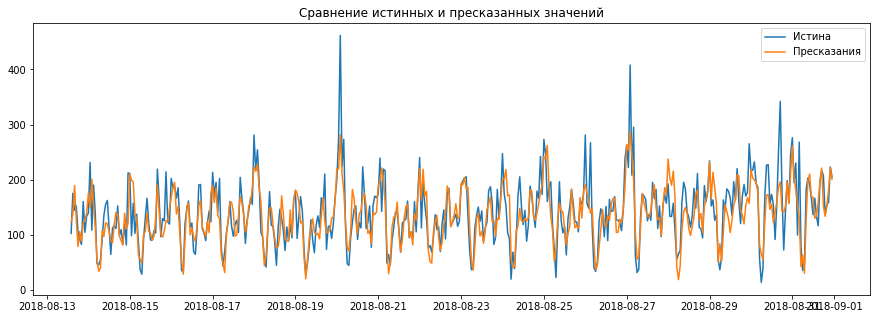

In [43]:
plt.figure(figsize=(15,5))
plt.plot(test_target, label='Истина')
plt.plot(test_target.index, test_predict, label='Пресказания')
plt.title('Сравнение истинных и пресказанных значений')
plt.legend();

**Промежуточный вывод**

- На основе проведенных моделирований временного ряда различными моделями была составлена таблица с рейтингом точности по метрике RMSE, по которой была выбрана лучшая модель - CatBoost. Ее также проверили на тестовых данных.
- Результат предсказания на тестовой части данных используя модель CatBoost удовлетворяет требованию заказчика.

## Итоговый вывод

В результате выполнения проекта решена задача и достигнута цель - подобрана лучше модель по метрике RMSE, которая не превышает требованию заказчика = 48. Лучшей моделью выбрана CatBoost.

При выполнении проекта были сделаны следующие задачи и получены выводы:

- Чтение данных и установка признака "datetime" в качестве индекса.
- Выполнено ресемплирование с интервалом в один час с агрегирующией функцией значения ряда - sum().
- Данные были отсортированы и преобразованы во временной ряд.
- Выяснено, что дубликатов и пропусков нет.
- Проведена проверка на монотонность временного ряда.
- Выяснено, что тип данных в столбце num_orders менять не надо. 
- Временной ряд имеет множественные колебания, в данных наблюдается плавное измение тренда за рассматриваемый период, ряд не стационарен. Однако, разности временного ряда являются стационарными. 
- Разложение временного ряда на тренд, сезонность и остаток показало линейное увеличение заказов на протяжении года.
- Видно, что в данных присутствует шум. 
- Сезонность была рассмотрена на двух временных отрезках - все данные (несколько месяцев) и на одной неделе (чтобы четко определить структуру данных). Анализ сезонности на всем временном отрезке ничего не показал, а вот на интревале в неделю присутствуют циклично-повторяющиеся закономерности, в данном случае мы видим, что рост количества заказов каждый день происходит в одинаковые часы (пик вечером), в воскресенье чуть меньше.
- Подготовленный временной ряд был разложен на обучающую и тестовую выборки в соотношении. 
- Обучающие данные были прогнаны через несколько моделей с различными гиперпараметрами.
- На лучшей модели проведено тестирование.
- На основе проведенных моделирований временного ряда различными моделями была составлена таблица с рейтингом точности по метрике RMSE, по которой была выбрана лучшая модель - CatBoost. Ее также проверили на тестовых данных.
- Результат предсказания на тестовой части данных используя модель CatBoost удовлетворяет требованию заказчика.